# CSX46 - Class Session 14 - Partial correlation network

In this class session we will continue with analyzing the tumor gene expression dataset from the NIH human bladder cancer cohort (*M*=414 tumors), building on what we learned in Class Session 19 (Correlation Network).  In order to keep the analysis simple&ast;, in this notebook will restrict our analysis to a set of *N*=164 genes that are very highly expressed in bladder cancer. Using the 164 x 414 matrix of transcript abundance measurements, we will construct a network based on gene-gene partial correlation coefficients. We will also compare the distribution of partial correlation coefficients to the distribution of Pearson correlation coefficients. Do you think they will be different?  In what way would you expect them to be different?

&ast; Here, "simple" means that the covariance matrix will be nonsingular, so that we can obtain the partial correlation matrix by inversion.

We'll import all of the python modules that we will need for this exercise

In [1]:
import pandas  ## data file loading
import numpy
import sklearn.covariance  ## for covariance matrix calculation
import matplotlib.pyplot
import matplotlib
import pylab
import scipy.stats  ## for calculating the CDF of normal distribution
import igraph  ## for network visualization and finding components
import math

Read the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples). (use Pandas, `pandas.read.csv`, and `as_matrix`). As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414) using `shape`.

In [2]:
gene_matrix_for_network_df = pandas.read_csv("shared/bladder_cancer_genes_tcga.txt", sep="\t")

Convert your data frame to a numpy matrix, using the `pandas.DataFrame.values` attribute.

In [3]:
gene_matrix_for_network = gene_matrix_for_network_df.values

As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414) using `shape`.

In [4]:
print(gene_matrix_for_network.shape)

(4473, 414)


Compute the median expression level for each row of your matrix

In [5]:
genes_median_expression = numpy.median(gene_matrix_for_network, axis=1)

Filter the matrix to include only rows for which the gene's median expression is > 12; matrix should now be 164 x 414; this will enable us to easily compute the partial correlation matrix using the inverse of the covariance matrix. Print the size of the filtered matrix, as a sanity check.

In [6]:
gene_matrix_np = numpy.array(gene_matrix_for_network)
genes_keep = numpy.where(genes_median_expression > 12)
matrix_filt = gene_matrix_np[genes_keep, ][0]
matrix_filt.shape
N = matrix_filt.shape[0]

Print the shape of your filtered matrix, as a sanity check.  It should be 164x414.

In [7]:
matrix_filt.shape

(164, 414)

Compute the 164 x 164 matrix of gene-gene Pearson correlation coefficients, using `numpy.corrcoef` (this function treats each row as a random variable, so you don't have to do any transposing of the matrix, unlike the situation in R). 

In [8]:
matrix_cor = numpy.corrcoef(matrix_filt)

Compute the covariance matrix using `sklearn.covariance.empirical_covariance` (from the `sklearn.covariance` package, . Make sure you take the transpose of the `matrix_filt` matrix before passing it to the `empirical_covariance` function!  

In [9]:
matrix_cov = sklearn.covariance.empirical_covariance(numpy.matrix.transpose(matrix_filt))

Use `numpy.linalg.inv` to get the inverse matrix. 

In [10]:
matrix_cov_inv = numpy.linalg.inv(matrix_cov)

Use a double for loop to "scale" the negative of the precision matrix, which will give you the partial correlation. Print the dimensions of the matrix you get back, as a sanity check. 

In [11]:
matrix_pcor = -matrix_cov_inv
for i in range(N):
    for j in range(N):
        matrix_pcor[i,j] /= numpy.sqrt(matrix_cov_inv[i,i]*matrix_cov_inv[j,j])
print(matrix_pcor.shape)

(164, 164)


Get the correlation coefficients and the partial correlation coefficients of the lower triangle of the matrix (not including the diagonal), as two vectors `cor_values` and `pcor_values`; your resulting vectors should each have length 13,366.  You will want to use `numpy.tri` and `numpy.where` (see class session 19 exercise)

In [12]:
cor_values = matrix_cor[numpy.where(numpy.tri(*matrix_cor.shape, k=-1))]
pcor_values = matrix_pcor[numpy.where(numpy.tri(*matrix_pcor.shape, k=-1))]
print(len(cor_values))
print(len(pcor_values))

13366
13366


plot the histograms of the correlation coefficients (upper triangle only) and the partial correlation coefficients, on the same plot using alpha blending (refer to class session 10 exercise)

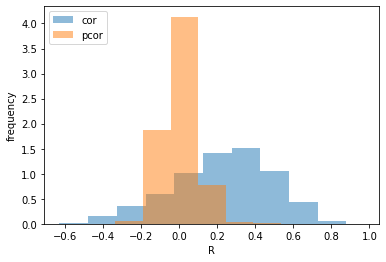

In [13]:
matplotlib.pyplot.hist(cor_values, density=True, alpha=0.5, label="cor")
matplotlib.pyplot.hist(pcor_values, density=True, alpha=0.5, label="pcor")
matplotlib.pyplot.legend(loc="upper left")
matplotlib.pyplot.xlabel("R")
matplotlib.pyplot.ylabel("frequency")
matplotlib.pyplot.show()

Fisher transform the partial correlation values, using `numpy.log`:

In [14]:
z_scores = 0.5*numpy.log((1+pcor_values)/
                         (1-pcor_values))

Compute a p-value for each gene pair (upper triangle only), using the fact that sqrt(M-N-5) times the fisher Z sore should be approximately univariate normal (with zero mean) under the null hypothesis that a given gene pair's measurements (conditioned on the measurements for all the other 162 genes) are independent. You will want to use `scipy.stats.norm.cdf`, `numpy.abs`, and `math.sqrt` function (see class session 13 exercise).

In [15]:
M = gene_matrix_for_network_df.shape[1]

P_values = 2*scipy.stats.norm.cdf(-numpy.abs(z_scores)*(math.sqrt((M-N-5))))

How many gene pairs have a P value less than 0.01? (use `which` and `length`)

In [16]:
len(numpy.where(P_values < 0.01)[0])

706

What are the sizes of the components in the undirected graph whose edges have `P < 0.05` in the statistical test that you did?  You will need to use `zip`, `tolist`, `list`, and `igraph.Graph.TupleList` (see class session 13 exercise)

In [17]:
inds_tri = numpy.where(numpy.tri(*matrix_pcor.shape, k=-1))
inds_sig = numpy.where(P_values < 0.01)
graph_edge_list = list(zip(inds_tri[1][inds_sig].tolist(),
                                                inds_tri[0][inds_sig].tolist()))
final_network = igraph.Graph.TupleList(graph_edge_list, directed=False)
final_network.summary()

'IGRAPH UN-- 164 706 -- \n+ attr: name (v)'

Plot the graph degree distribution on log-log scale

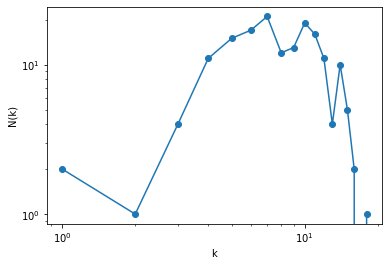

In [18]:
degree_dist = final_network.degree_distribution()
xs, ys = zip(*[(left, count) for left, _, count in degree_dist.bins()])
matplotlib.pyplot.loglog(xs, ys, marker="o")
pylab.xlabel("k")
pylab.ylabel("N(k)")
pylab.show()